<a href="https://colab.research.google.com/github/DMXMax/covid19/blob/gc_20200315/coviddata.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests,json


In [0]:
covidtrackingurl = "https://covidtracking.com/api/states/daily"
response = requests.get(covidtrackingurl)
dfCovidtracking = pd.DataFrame(response.json())
dfCovidtracking.fillna(0, inplace=True)
dfCovidtracking.negative = dfCovidtracking.negative.astype('int64')
dfCovidtracking.positive = dfCovidtracking.positive.astype('int64')
dfCovidtracking.pending = dfCovidtracking.pending.astype('int64')
dfCovidtracking.total = dfCovidtracking.total.astype('int64')
dfCovidtracking.death = dfCovidtracking.death.astype('int64')


In [0]:
dfWHO = pd.read_csv("https://raw.githubusercontent.com/DMXMax/covid19/master/who/who_data.tsv",
                     sep='\t', index_col='Date')

In [0]:
jhurl = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/"+\
"csse_covid_19_data/csse_covid_19_daily_reports/03-23-2020.csv"
dfJHUData = pd.read_csv(jhurl, header=0,
                        names=['FIPS', 'city','state', 'country', 'last_update',
                               'lat', 'lon','confirmed', 'dead', 'recovered','active', 'key'])

In [0]:
dfWHO = dfWHO.rename(columns={"Confirmed": "confirmed", "Deaths": "who_deaths"})
dfWHO.index.names=['date']


In [6]:
us_pop = 329968629  #Estimate from Wikipedia
res = dfCovidtracking.loc[dfCovidtracking.date==dfCovidtracking.date.max(), ['positive', 'negative', 'pending', 'total']].sum()
print(res)
print(f"Current Infection Rate {res.positive/res.total*100:2f}%")
print(f"Percentage of US: {res.positive/us_pop*100:2f}%")

positive     42164
negative    237321
pending      14571
total       294056
dtype: int64
Current Infection Rate 14.338765%
Percentage of US: 0.012778%


In [7]:
dfCovidtracking.loc[dfCovidtracking.date==dfCovidtracking.date.max(),['state', 'positive']].sort_values(by='positive', ascending=False).head(10)

,state,positive
37,NY,20875
34,NJ,2844
52,WA,1996
5,CA,1733
24,MI,1328
16,IL,1285
20,LA,1172
10,FL,1171
21,MA,777
11,GA,772


In [0]:
#Compare growth from 20200311 and 202020313
dtstart = 20200311
dtend = 20200317
dfCA = dfCovidtracking[dfCovidtracking.state=='CA']

In [9]:
arCols = ['positive', 'negative', 'death']
arTotCols= ['positive', 'negative']

dfUSAstart = dfCovidtracking.loc[dfCovidtracking.date == dtstart, arCols].sum()
print(dfUSAstart)
print(dfUSAstart.loc[arTotCols].sum())
dfUSAend = dfCovidtracking.loc[dfCovidtracking.date == dtend, arCols].sum()
print(dfUSAend)
print(dfUSAend.loc[arTotCols].sum())


positive    1053
negative    5978
death         27
dtype: int64
7031
positive     5723
negative    47604
death          90
dtype: int64
53327


In [0]:
gbUSA = dfCovidtracking.groupby(['date'])
gbCA = dfCovidtracking[dfCovidtracking.state=='CA'].groupby(['date'])

dfUSAPos = gbUSA.positive.sum().reset_index().copy()
dfCAPos = gbCA.positive.sum().reset_index().copy()

#This will calculate the percentage each day is of the total. In a flattening, this will be more even
# In a high growth situation, you'll higher percentages at the tail. 
dfUSAPos['PCT']= dfUSAPos.positive/dfUSAPos.max().positive
dfCAPos['PCT']=dfCAPos.positive/dfCAPos.max().positive

In [11]:
dfUSAPos[-7:]

,date,positive,PCT
13,20200317,5723,0.135732
14,20200318,7731,0.183355
15,20200319,11723,0.278033
16,20200320,17038,0.404089
17,20200321,23203,0.550304
18,20200322,31888,0.756285
19,20200323,42164,1.000000


In [12]:
dfCAPos[-7:]

,date,positive,PCT
13,20200317,483,0.278707
14,20200318,611,0.352568
15,20200319,924,0.533179
16,20200320,1063,0.613387
17,20200321,1279,0.738027
18,20200322,1536,0.886324
19,20200323,1733,1.000000


In [13]:
gbUSA.sum()[-5:]

,positive,negative,pending,hospitalized,death,total
date,,,,,,
20200319,11723,89119,3025,0.0,160,103867
20200320,17038,118147,3336,0.0,219,138521
20200321,23203,155909,3477,1964.0,272,182589
20200322,31888,193463,2842,2554.0,398,228216
20200323,42164,237321,14571,3325.0,471,294056


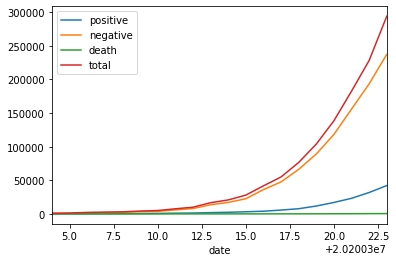

In [14]:
gbUSA.sum().loc[:, ['positive', 'negative','death','total']].plot.line()

In [15]:
dfWHO[-14:]

,confirmed,who_deaths
date,,
20200310,472,19
20200311,696,25
20200312,987,29
20200313,1264,36
20200314,1678,41
20200315,1678,41
20200316,1678,41
20200317,3503,58
20200318,3536,58


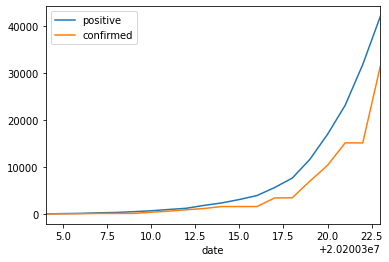

In [16]:
dfResults = gbUSA.sum().join(dfWHO, how='left', rsuffix='_who' )
dfResults.loc[:, ['positive', 'confirmed']].plot.line()

In [17]:
dfResults.tail()

,positive,negative,pending,hospitalized,death,total,confirmed,who_deaths
date,,,,,,,,
20200319,11723,89119,3025,0.0,160,103867,7087,100
20200320,17038,118147,3336,0.0,219,138521,10442,150
20200321,23203,155909,3477,1964.0,272,182589,15219,201
20200322,31888,193463,2842,2554.0,398,228216,15219,201
20200323,42164,237321,14571,3325.0,471,294056,31573,402


In [18]:
gbCA.sum()[-7:]

,positive,negative,pending,hospitalized,death,total
date,,,,,,
20200317,483,7981,0,0.0,11,8407
20200318,611,7981,0,0.0,13,8592
20200319,924,8787,0,0.0,18,9711
20200320,1063,10424,0,0.0,20,11487
20200321,1279,11249,0,0.0,24,12528
20200322,1536,11304,0,0.0,27,12840
20200323,1733,12567,12100,0.0,27,26400


In [19]:
dfJHUData[dfJHUData.country=='US'][['confirmed', 'dead']].sum()

confirmed    43667
dead           552
dtype: int64

In [20]:
dfJHUData[(dfJHUData.country=='US')&(dfJHUData.state=='California')][['confirmed', 'dead']].sum()

confirmed    2108
dead           39
dtype: int64

In [0]:
dfJHUUS = dfJHUData[dfJHUData.country=='US']
gbJHUByState= dfJHUUS.groupby(by='state')
gbJHUByCountry = dfJHUData.groupby(by='country')

In [22]:
gbJHUByCountry.confirmed.sum().sort_values(ascending=False).head(10)

country
China             81496
Italy             63927
US                43667
Spain             35136
Germany           29056
Iran              23049
France            20123
Korea, South       8961
Switzerland        8795
United Kingdom     6726
Name: confirmed, dtype: int64

In [23]:
gbJHUByCountry.confirmed.sum().sort_values(ascending=False).head(20)

country
China             81496
Italy             63927
US                43667
Spain             35136
Germany           29056
Iran              23049
France            20123
Korea, South       8961
Switzerland        8795
United Kingdom     6726
Netherlands        4764
Austria            4474
Belgium            3743
Norway             2621
Canada             2088
Portugal           2060
Sweden             2046
Brazil             1924
Australia          1682
Denmark            1572
Name: confirmed, dtype: int64

In [0]:
dfData = dfCovidtracking.groupby('date')

In [0]:
dfStateTotal = dfCovidtracking[['state', 'positive']].groupby(by='state').max() \
.rename(columns={'positive':'current_total'})


In [0]:
dfState = dfCovidtracking[['date','state','positive']].set_index('state') \
  .join(dfStateTotal)

In [0]:
dfState['pct']=dfState.positive/dfState.current_total

In [28]:
dfState.loc['NY']

,date,positive,current_total,pct
state,,,,
NY,20200323,20875,20875,1.000000
NY,20200322,15168,20875,0.726611
NY,20200321,10356,20875,0.496096
NY,20200320,7102,20875,0.340216
NY,20200319,4152,20875,0.198898
NY,20200318,2382,20875,0.114108
NY,20200317,1700,20875,0.081437
NY,20200316,950,20875,0.045509
NY,20200315,729,20875,0.034922


In [0]:
res = dfState.reset_index().pivot(index = 'date', columns='state', values='pct').fillna(0)

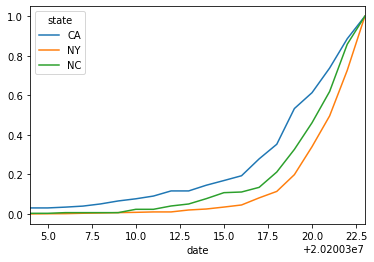

In [31]:
res.loc[:, ['CA','NY','NC']].plot.line()

In [0]:
dfNYTesting = dfCovidtracking.loc[dfCovidtracking.state=='NY', ['date', 'negative']].set_index('date')

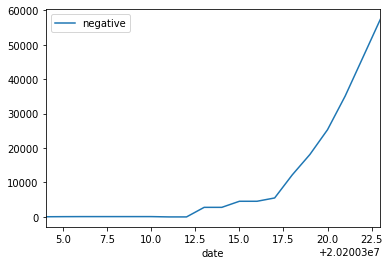

In [34]:
dfNYTesting.plot.line()

In [0]:
dfDates = dfState.reset_index()

In [36]:
dfDates[(dfDates.state.isin(['CA'])) & (dfDates.date>20200318)]

,state,date,positive,current_total,pct
81,CA,20200323,1733,1733,1.000000
82,CA,20200322,1536,1733,0.886324
83,CA,20200321,1279,1733,0.738027
84,CA,20200320,1063,1733,0.613387
85,CA,20200319,924,1733,0.533179
